## Heart Rate Monitoring During Physical Exercise Using Wrist-Type Photoplethysmographic (PPG) Signals with Fedot.Industrial

The goal of this dataset is to estimate heart rate using PPG sensors. This dataset contains 3096, 5 dimensional time series obtained from the IEEE Signal Processing Cup 2015: Heart Rate Monitoring During Physical Exercise Using Wrist-Type Photoplethysmographic (PPG) Signals. Two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals were simultaneously recorded from subjects with age from 18 to 35. For each subject, the PPG signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm). Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband, which was comfortably worn. The ECG signal was recorded simultaneously from the chest using wet ECG sensors. All signals were sampled at 125 Hz and sent to a nearby computer via Bluetooth.
Link to the dataset - https://zenodo.org/record/3902710

In [1]:
import pandas as pd
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
from fedot_ind.api.main import FedotIndustrial

In [2]:
def evaluate_loop(api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

The list of basic fedot industrial models for experiment are shown below. We are using simple linear machine learning pipelines with 3 different feature generators: Statistical, Recurrence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [3]:
initial_assumption = PipelineBuilder().add_node('quantile_extractor').add_node('treg')
params = dict(problem='regression',
                             metric='rmse',
                             timeout=15,
                             initial_assumption=initial_assumption,
                             n_jobs=2,
                             logging_level=20)
dataset_name = 'IEEEPPG'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-04-04 13:50:15,094 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/IEEEPPG


In [5]:
import numpy as np
features = np.array(train_data[0].values.tolist()).astype(float)

Lets check our data.

In [6]:
features.shape

(1768, 5, 1000)

Lets visualise our predictors.

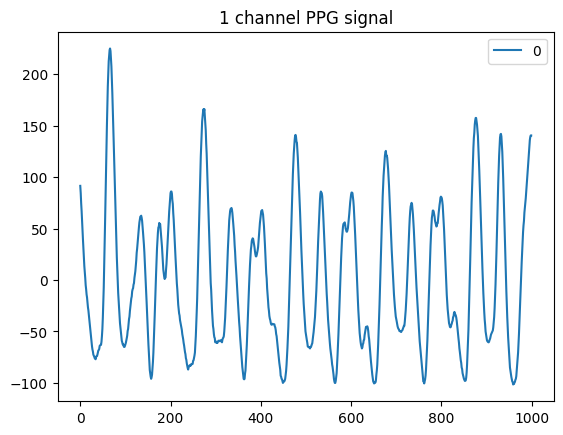

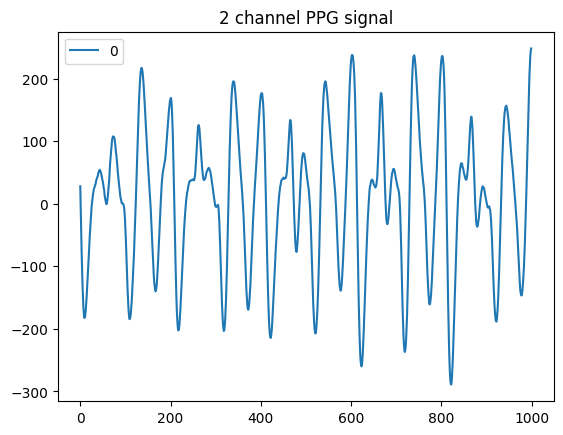

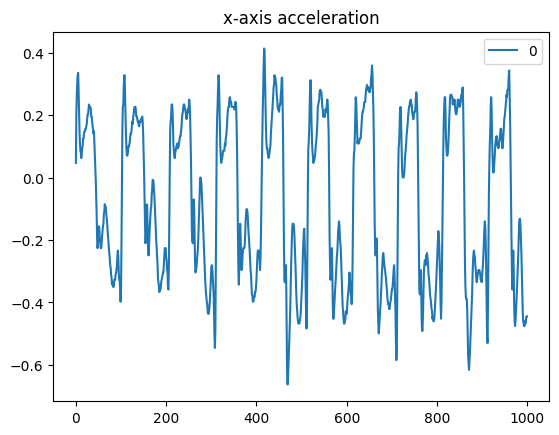

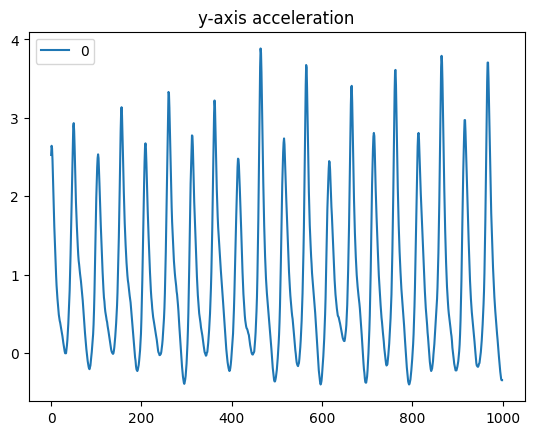

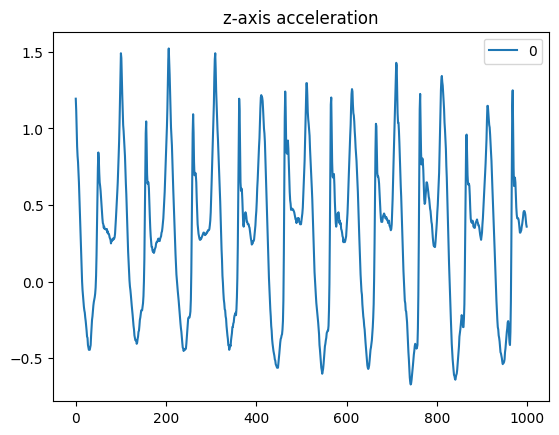

In [7]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='1 channel PPG signal')
pd.DataFrame(features[1, 1, :]).plot(title='2 channel PPG signal')
pd.DataFrame(features[1, 2, :]).plot(title='x-axis acceleration')
pd.DataFrame(features[1, 3, :]).plot(title='y-axis acceleration')
pd.DataFrame(features[1, 4, :]).plot(title='z-axis acceleration')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [8]:
industrial_model =  evaluate_loop(api_params=params, finetune=True)

2024-04-04 13:50:55,492 - Initialising experiment setup
2024-04-04 13:50:55,692 - Initialising Industrial Repository
2024-04-04 13:50:56,560 - Initialising Dask Server
Creating Dask Server
2024-04-04 13:50:57,292 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-04-04 13:50:57,327 - State start
2024-04-04 13:50:57,584 -   Scheduler at: inproc://10.64.4.217/16776/1
2024-04-04 13:50:57,585 -   dashboard at:  http://10.64.4.217:54489/status
2024-04-04 13:50:57,585 - Registering Worker plugin shuffle
2024-04-04 13:50:57,847 -       Start worker at: inproc://10.64.4.217/16776/4
2024-04-04 13:50:57,848 -          Listening to:          inproc10.64.4.217
2024-04-04 13:50:57,849 -           Worker name:                          0
2024-04-04 13:50:57,849 -          dashboard at:          10.64.4.217:54490
2024-04-04 13:50:57,850 - Waiting to connect to: inproc://10.64.4.217/16776/1
2024-04-04 13:50:57,850 - --------

[I 2024-04-04 14:32:21,219] A new study created in memory with name: no-name-c31c952a-94a0-40dc-b2e8-4c418a58f4b4


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-04 14:40:57,273] Trial 2 finished with value: 16.015211426663093 and parameters: {'0 || treg | max_features': 0.5516641026533903, '0 || treg | min_samples_split': 16, '0 || treg | min_samples_leaf': 16, '0 || treg | bootstrap': False}. Best is trial 2 with value: 16.015211426663093.
[I 2024-04-04 14:40:57,609] Trial 3 finished with value: 16.7691397749222 and parameters: {'0 || treg | max_features': 0.8338964649857422, '0 || treg | min_samples_split': 10, '0 || treg | min_samples_leaf': 15, '0 || treg | bootstrap': True}. Best is trial 2 with value: 16.015211426663093.
[I 2024-04-04 14:40:57,937] Trial 4 finished with value: 14.772304333793825 and parameters: {'0 || treg | max_features': 0.6949383225249334, '0 || treg | min_samples_split': 15, '0 || treg | min_samples_leaf': 4, '0 || treg | bootstrap': True}. Best is trial 4 with value: 14.772304333793825.
[I 2024-04-04 14:40:58,199] Trial 1 finished with value: 16.079741587423836 and parameters: {'0 || treg | max_features':

In [9]:
labels = industrial_model.predict(test_data)
metrics = industrial_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [10]:
metrics

,r2,rmse,mae
0,0.089,29.674,24.49


## AutoML approach

In [11]:
industrial_auto_model = evaluate_loop(api_params=params, finetune=False)

2024-04-04 15:10:51,790 - Initialising experiment setup
2024-04-04 15:10:51,987 - Initialising Industrial Repository
2024-04-04 15:10:51,988 - Initialising Dask Server
Creating Dask Server
2024-04-04 15:10:52,007 - State start
2024-04-04 15:10:52,527 -   Scheduler at: inproc://10.64.4.217/16776/9
2024-04-04 15:10:52,528 -   dashboard at:  http://10.64.4.217:56162/status
2024-04-04 15:10:52,528 - Registering Worker plugin shuffle
2024-04-04 15:10:53,038 -       Start worker at: inproc://10.64.4.217/16776/12
2024-04-04 15:10:53,039 -          Listening to:          inproc10.64.4.217
2024-04-04 15:10:53,039 -           Worker name:                          0
2024-04-04 15:10:53,040 -          dashboard at:          10.64.4.217:56165
2024-04-04 15:10:53,040 - Waiting to connect to: inproc://10.64.4.217/16776/9
2024-04-04 15:10:53,041 - -------------------------------------------------
2024-04-04 15:10:53,042 -               Threads:                          8
2024-04-04 15:10:53,042 -     

ValueError: Probabilities of predictions are available only for classification

In [12]:
auto_labels = industrial_auto_model.predict(test_data)
auto_metrics = industrial_auto_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [13]:
auto_metrics

,r2,rmse,mae
0,0.077,29.869,24.641


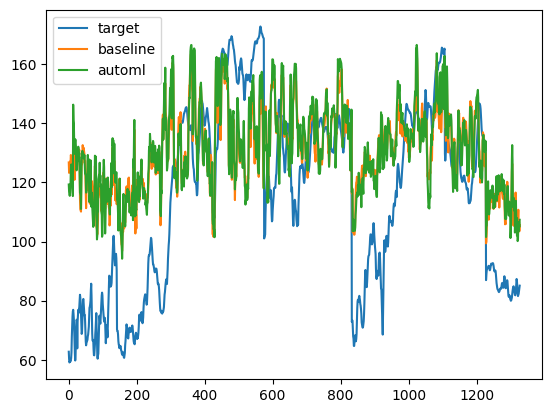

In [14]:
predictions = np.vstack([test_data[1].flatten(), labels.flatten(), auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions, columns=['target', 'baseline', 'automl'])
all_prediction.plot()
plt.show()

In [22]:
import numpy as np
features = np.array(test_data[0].values.tolist()).astype(float)

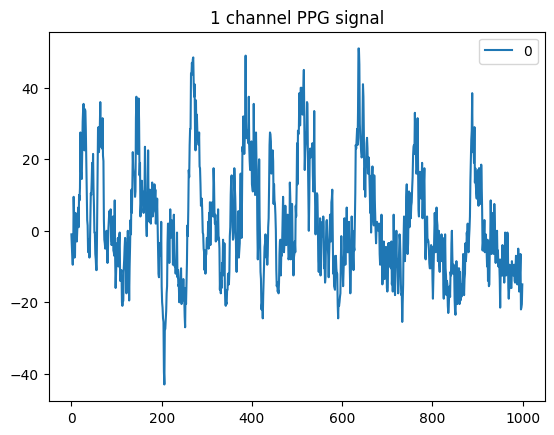

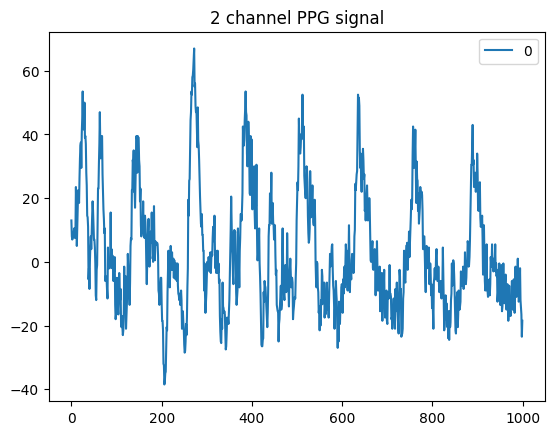

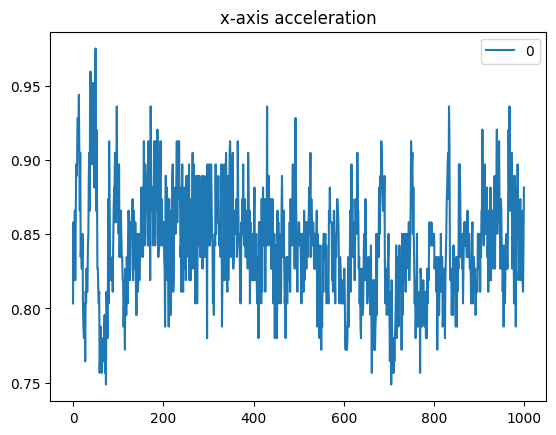

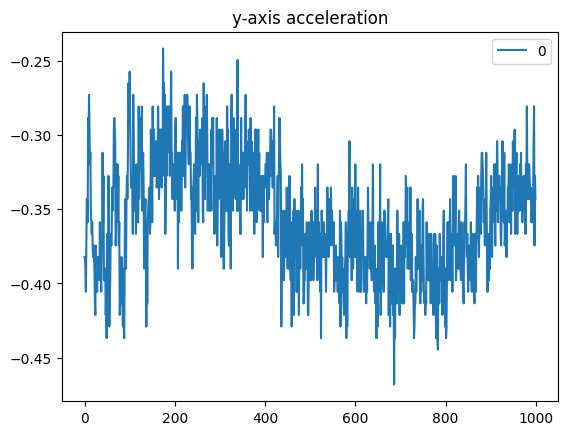

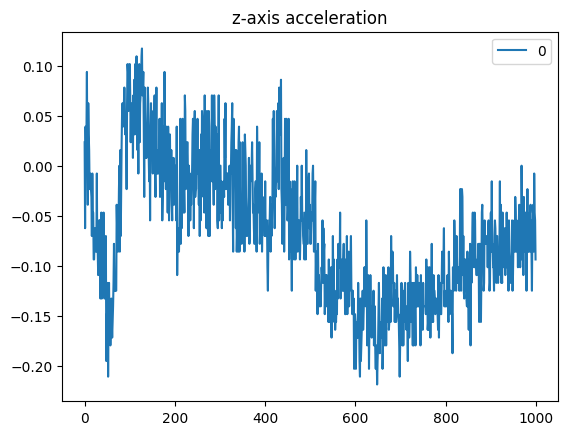

In [23]:
pd.DataFrame(features[1, 0, :]).plot(title='1 channel PPG signal')
pd.DataFrame(features[1, 1, :]).plot(title='2 channel PPG signal')
pd.DataFrame(features[1, 2, :]).plot(title='x-axis acceleration')
pd.DataFrame(features[1, 3, :]).plot(title='y-axis acceleration')
pd.DataFrame(features[1, 4, :]).plot(title='z-axis acceleration')
plt.show()

## Compare with State of Art (SOTA) models

In [15]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')

In [16]:
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [17]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [18]:
df.sort_values('min')

algorithm,min,max,average
InceptionT_RMSE,2.326973,23.144061,3.698176
SingleInception_RMSE,2.862294,24.226917,4.119866
ResNet_RMSE,3.517166,33.038647,5.051279
FCN_RMSE,4.934538,36.772476,7.190419
ROCKET_RMSE,6.016981,27.583495,7.159721
RIST_RMSE,6.967740,27.277590,11.477876
MultiROCKET_RMSE,7.536678,29.900533,8.771684
RDST_RMSE,8.051669,25.700414,11.626389
FreshPRINCE_RMSE,8.489912,33.689079,10.115907
DrCIF_RMSE,11.201905,34.916949,12.474585


In [19]:
df.sort_values('max')

algorithm,min,max,average
RotF_RMSE,19.284382,20.824608,20.212812
InceptionT_RMSE,2.326973,23.144061,3.698176
SingleInception_RMSE,2.862294,24.226917,4.119866
RDST_RMSE,8.051669,25.700414,11.626389
5NN-ED_RMSE,22.438166,27.111213,23.655007
RIST_RMSE,6.967740,27.277590,11.477876
ROCKET_RMSE,6.016981,27.583495,7.159721
Fedot_Industrial_tuned,29.674000,29.674000,29.674000
Fedot_Industrial_AutoML,29.869000,29.869000,29.869000
MultiROCKET_RMSE,7.536678,29.900533,8.771684


In [20]:
df.sort_values('average')

algorithm,min,max,average
InceptionT_RMSE,2.326973,23.144061,3.698176
SingleInception_RMSE,2.862294,24.226917,4.119866
ResNet_RMSE,3.517166,33.038647,5.051279
ROCKET_RMSE,6.016981,27.583495,7.159721
FCN_RMSE,4.934538,36.772476,7.190419
MultiROCKET_RMSE,7.536678,29.900533,8.771684
FreshPRINCE_RMSE,8.489912,33.689079,10.115907
RIST_RMSE,6.967740,27.277590,11.477876
RDST_RMSE,8.051669,25.700414,11.626389
DrCIF_RMSE,11.201905,34.916949,12.474585
